<a href="https://colab.research.google.com/github/nispoe/GWU-SEAS-8525/blob/main/class-3/class-3-VAE-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Variational Autoencoder**

The code defines two functions: `sample_batch` and `display`.

1. `sample_batch(dataset)`:
   - This function takes a `dataset` as input.
   - It uses the `take(1)` method to retrieve a single batch from the dataset and then calls `get_single_element()` to extract the actual batch data.
   - If the batch is a tuple, it assumes that the first element of the tuple represents the batch data and assigns it to `batch`.
   - Finally, it returns the batch data as a NumPy array using `batch.numpy()`.

2. `display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None)`:
   - This function is used to display a grid of images.
   - It takes the following parameters:
     - `images`: An array or tensor containing the images to be displayed.
     - `n`: The number of images to display (default is 10).
     - `size`: The size of the figure in inches (default is (20, 3)).
     - `cmap`: The colormap to use for displaying the images (default is "gray_r" for grayscale images).
     - `as_type`: The data type to cast the images to (default is "float32").
     - `save_to`: A file path to save the displayed figure (optional).
   - The function first normalizes the pixel values of the images:
     - If the maximum value is greater than 1.0, it divides the images by 255.0 to scale them to the range [0, 1].
     - If the minimum value is less than 0.0, it adds 1.0 to the images and then divides by 2.0 to scale them to the range [0, 1].
   - It creates a new figure with the specified size using `plt.figure(figsize=size)`.
   - It iterates over the first `n` images in the `images` array.
   - For each image, it creates a subplot using `plt.subplot(1, n, i + 1)` to arrange the images in a single row.
   - It displays the image using `plt.imshow()`, passing the image data, colormap, and data type.
   - It removes the axis labels and ticks using `plt.axis("off")`.
   - If `save_to` is provided, it saves the figure to the specified file path using `plt.savefig(save_to)` and prints a message indicating the file path.
   - Finally, it displays the figure using `plt.show()`.

These functions provide a convenient way to sample a batch of data from a dataset and display a grid of images with optional normalization and saving capabilities.

In [1]:
import matplotlib.pyplot as plt
import os


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

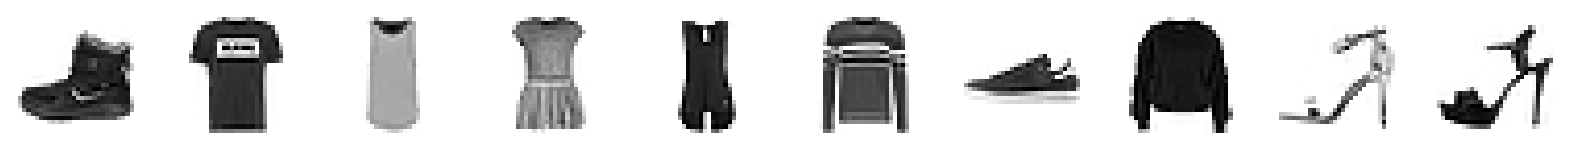

In [6]:
# Show some items of clothing from the training set
display(x_train)

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [11]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [12]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/model.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [14]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - kl_loss: 3.6660 - reconstruction_loss: 199.7769 - total_loss: 203.4429 - val_kl_loss: 4.9551 - val_loss: 141.6568 - val_reconstruction_loss: 136.7017
Epoch 2/5
  7/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - kl_loss: 4.8986 - reconstruction_loss: 128.4293 - total_loss: 133.3279  

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 5.0355 - reconstruction_loss: 131.8731 - total_loss: 136.9086 - val_kl_loss: 5.1198 - val_loss: 138.6429 - val_reconstruction_loss: 133.5231
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 5.0218 - reconstruction_loss: 129.6798 - total_loss: 134.7016 - val_kl_loss: 4.9365 - val_loss: 137.6964 - val_reconstruction_loss: 132.7599
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - kl_loss: 5.0355 - reconstruction_loss: 128.6649 - total_loss: 133.7003 - val_kl_loss: 5.1395 - val_loss: 137.0654 - val_reconstruction_loss: 131.9260
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - kl_loss: 5.0883 - reconstruction_loss: 128.0056 - total_loss: 133.0939 - val_kl_loss: 5.1679 - val_loss: 136.2820 - val_reconstruction_loss: 131.1141


In [15]:
# Save the final models
# vae.save("./models/vae")
# encoder.save("./models/encoder")
# decoder.save("./models/decoder")

# Create the models directory if it doesn't exist
os.makedirs("./models", exist_ok=True)

# Save the final models
vae.save("./models/vae.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

In [16]:
# Select a subset of the test set
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Example real clothing items


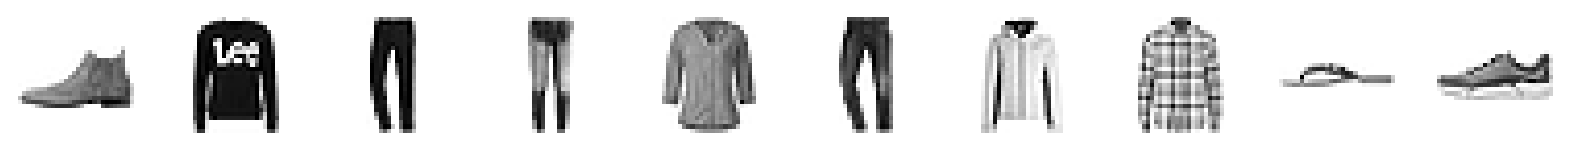

Reconstructions


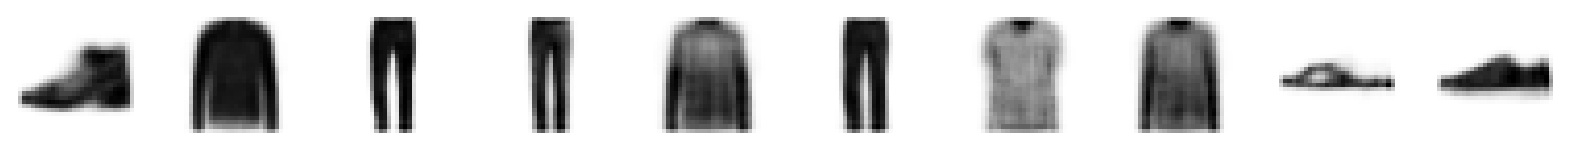

In [17]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

In [18]:
# Encode the example images
z_mean, z_var, z = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [19]:
# Some examples of the embeddings
print(z[:10])

[[ 1.4821342   0.10330519]
 [-0.13003735 -1.1013541 ]
 [-2.7616043   0.07301816]
 [-1.6442374   1.6730319 ]
 [-0.07820697 -0.08878224]
 [-1.8130884   0.42197168]
 [-0.37217754  0.9609859 ]
 [-0.17737903  0.26664352]
 [ 0.83895767  2.7641785 ]
 [ 1.1701596   1.4994574 ]]


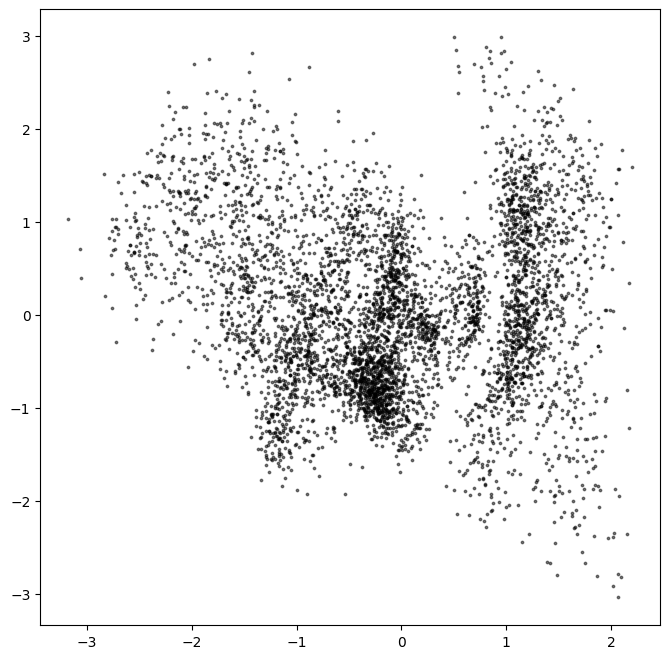

In [20]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [21]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [22]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


In [23]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

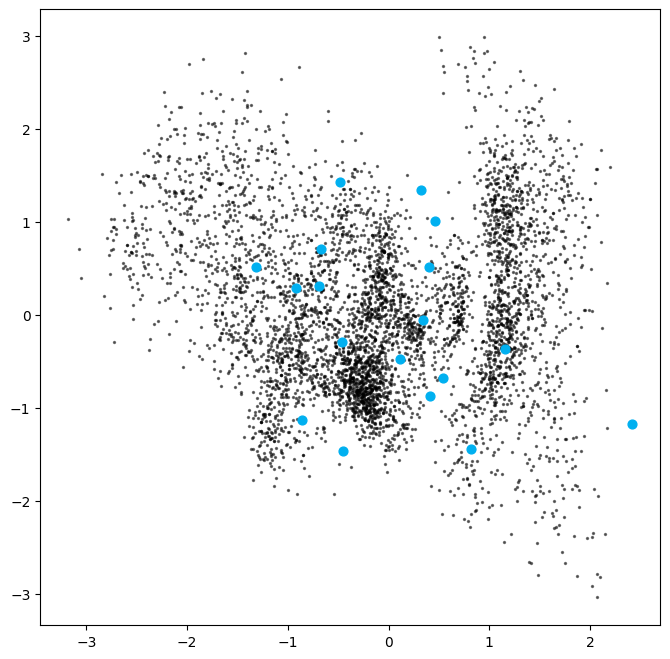

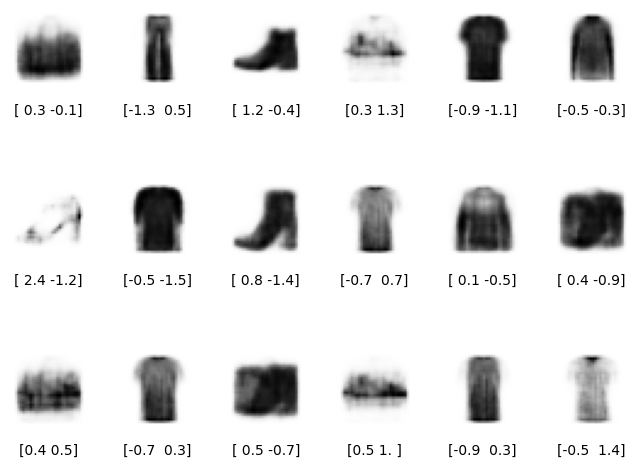

In [24]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

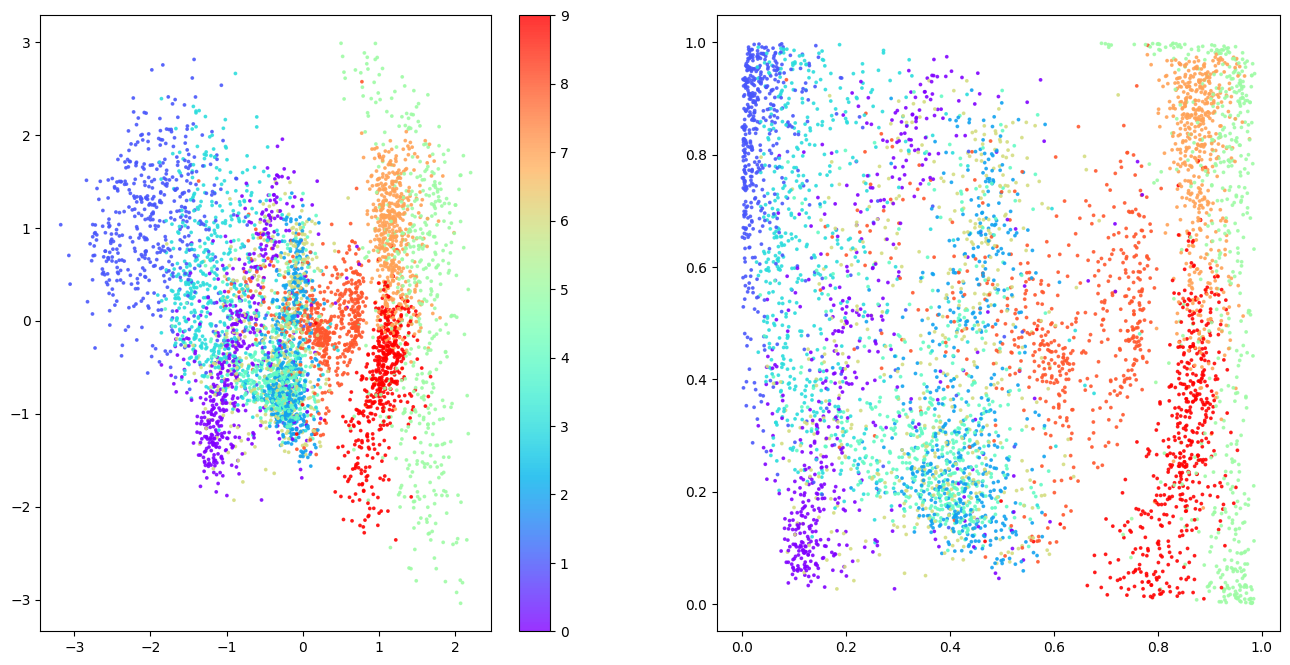

In [25]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

ID	Clothing Label
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


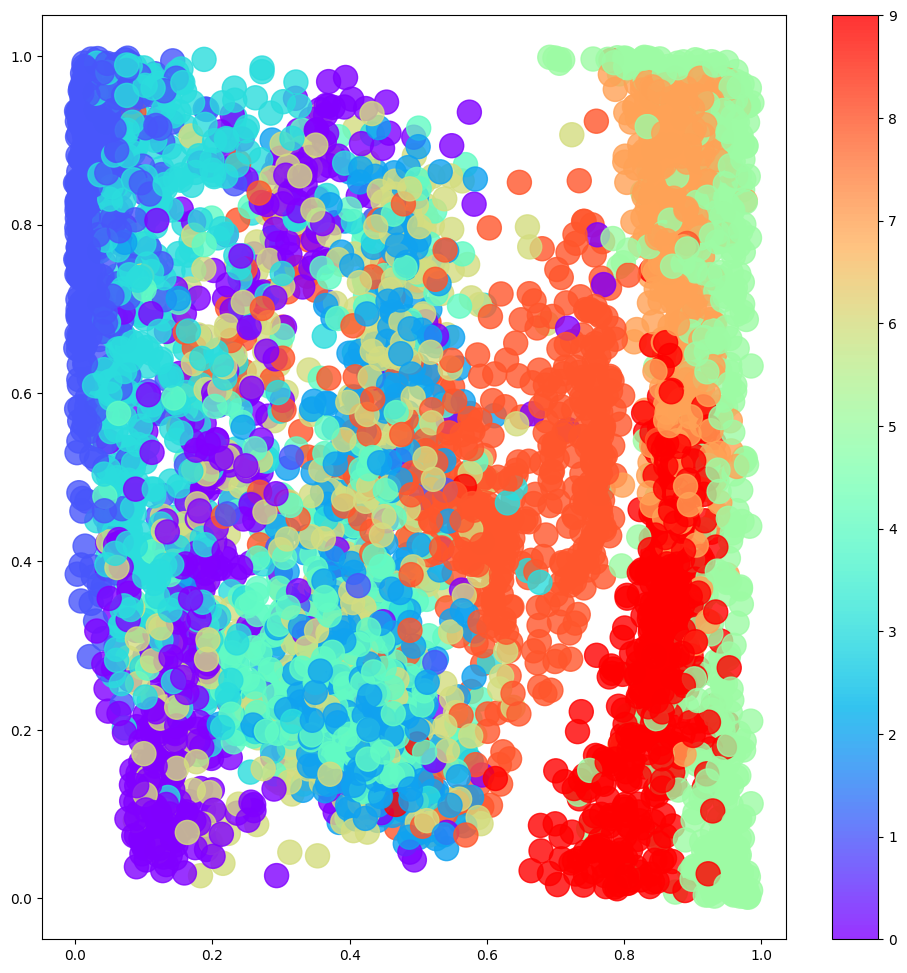

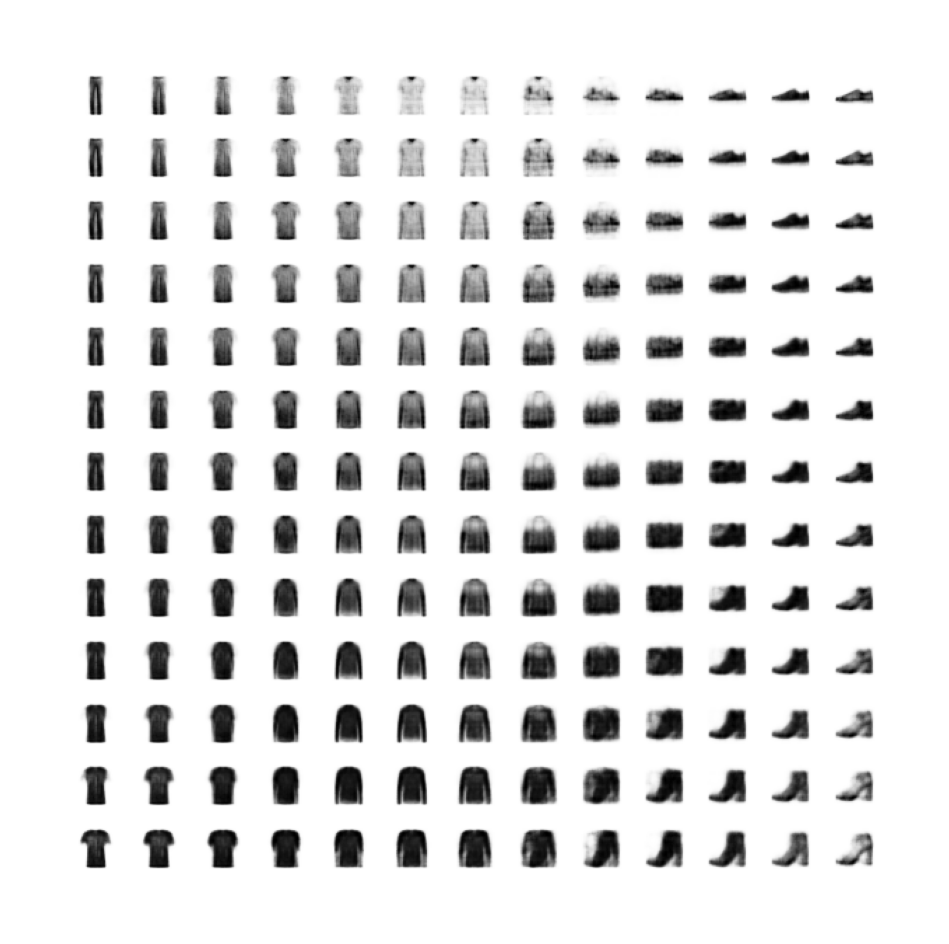

In [26]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

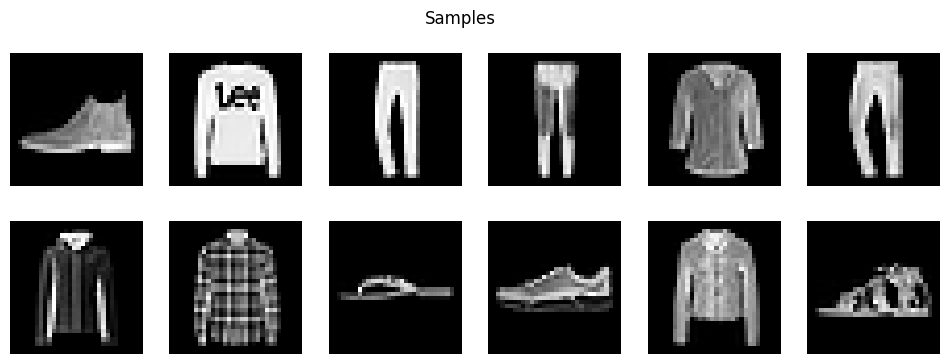

In [35]:
#1 - Minimal setup + data shape
import numpy as np, matplotlib.pyplot as plt, tensorflow as tf

def to_32x32(x):
    x = x.astype("float32")
    if x.ndim == 3: x = x[..., None]
    if x.shape[1:3] == (28, 28):
        x = tf.image.resize(x, (32, 32)).numpy()
    if x.max() > 1: x = x / 255.0
    return x

x_test32 = to_32x32(x_test)

def show_grid(images, n=12, title=""):
    n = min(n, images.shape[0]); cols = 6; rows = (n + cols - 1)//cols
    plt.figure(figsize=(2*cols, 2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1); plt.imshow(images[i].squeeze(), cmap="gray")
        plt.axis("off")
    if title: plt.suptitle(title); plt.show()

show_grid(x_test32, 12, "Samples")


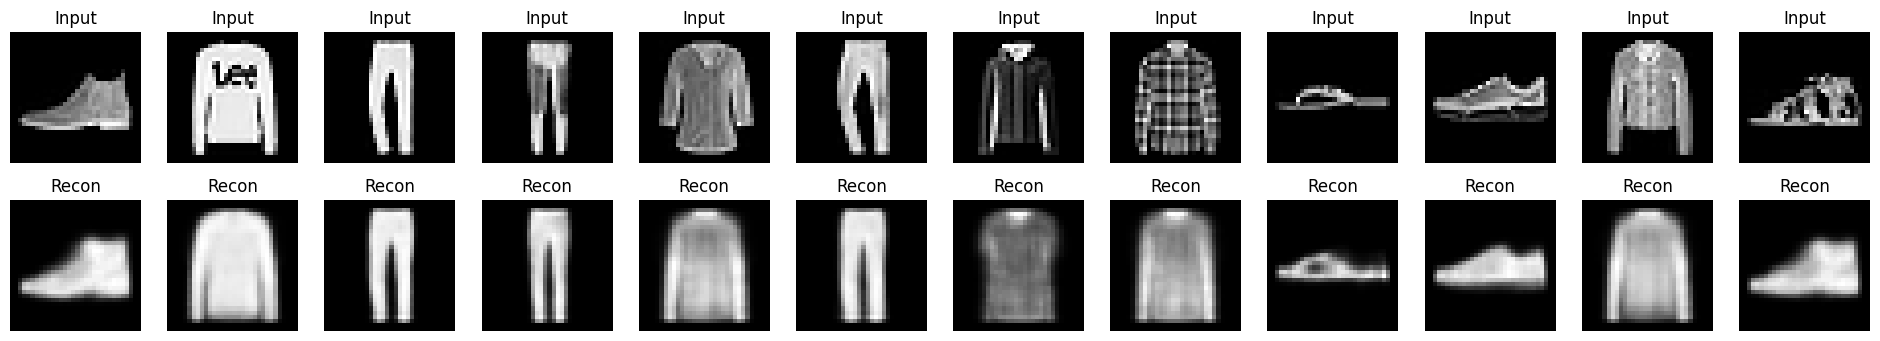

In [36]:
#2 - Reconstructions
# Try VAE.predict(x) -> recon; fallback to encoder->decoder
try:
    recon = vae.predict(x_test32[:24], verbose=0)  # change 'vae' to your VAE var if needed
    if isinstance(recon, (list, tuple)) or recon is None:
        raise ValueError
except Exception:
    z_mean, z_log_var, z = encoder.predict(x_test32[:24], verbose=0)
    recon = decoder.predict(z, verbose=0)

pairs = min(12, recon.shape[0])
plt.figure(figsize=(2*pairs, 4))
for i in range(pairs):
    plt.subplot(2, pairs, i+1); plt.imshow(x_test32[i].squeeze(), cmap="gray"); plt.axis("off"); plt.title("Input")
    plt.subplot(2, pairs, i+1+pairs); plt.imshow(recon[i].squeeze(), cmap="gray"); plt.axis("off"); plt.title("Recon")
plt.show()


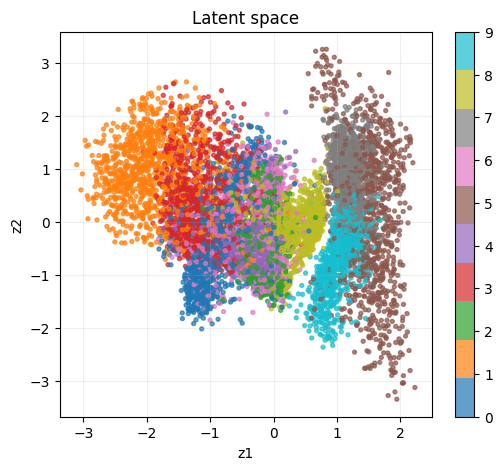

In [37]:
#3 - Latent scatter
z_mean, z_log_var, z = encoder.predict(x_test32, verbose=0)
labels = y_test if 'y_test' in globals() else np.zeros((z.shape[0],), dtype=int)

plt.figure(figsize=(6,5))
plt.scatter(z[:,0], z[:,1] if z.shape[1] > 1 else np.zeros_like(z[:,0]),
            c=labels, s=8, cmap="tab10", alpha=0.7)
plt.xlabel("z1"); plt.ylabel("z2"); plt.title("Latent space"); plt.grid(alpha=0.2); plt.colorbar()
plt.show()


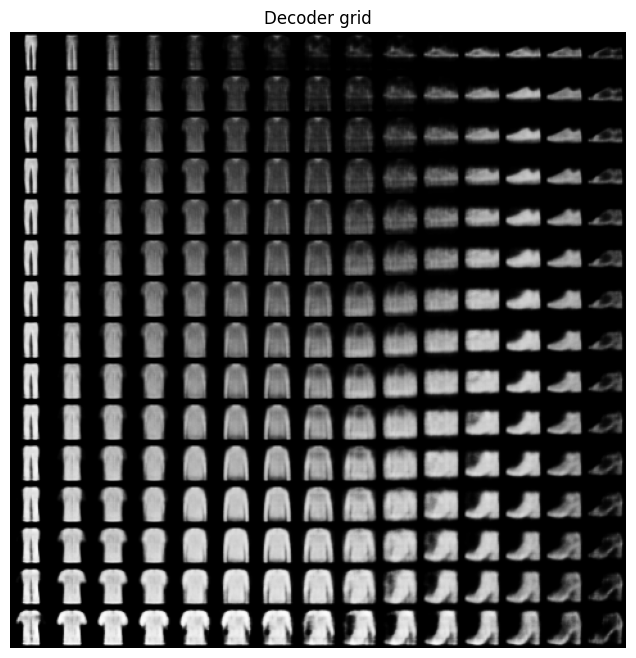

In [39]:
#4 - Decoder grid
from scipy.stats import norm

grid = 15
lin = np.linspace(0.02, 0.98, grid)
g = norm.ppf(lin)
canvas = np.zeros((32*grid, 32*grid), dtype="float32")

for i, a in enumerate(g):
    for j, b in enumerate(g):
        z_point = np.array([[a, b if z.shape[1] > 1 else 0.0]], dtype="float32")
        img = decoder.predict(z_point, verbose=0)[0].squeeze()
        canvas[(grid-1-j)*32:(grid-j)*32, i*32:(i+1)*32] = img

plt.figure(figsize=(8,8)); plt.imshow(canvas, cmap="gray"); plt.axis("off"); plt.title("Decoder grid"); plt.show()
